In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import numpy as np
import cv2
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import PIL
import PIL.Image
import glob
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
autotune = tf.data.experimental.AUTOTUNE
input_img_size = (256,256, 3)

orig_img_size = (280, 280)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 16

데이터 세트 준비

In [ ]:

train_y_filenames = glob.glob('../data/endoscope/adenoma/*.jpg')

train_x_filenames = [f.replace('/adenoma', '/patch') for f in train_y_filenames]
train_x = np.zeros((len(train_x_filenames),256,256,3))
train_y = np.zeros((len(train_y_filenames),256,256,3))

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img):
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

for (index, image) in enumerate(train_x_filenames[:]):
    
    img=np.array(PIL.Image.open(image))
    train_x[index] = img
# 훈련용 마스크 답지  및 병변여부 
for (index, image) in enumerate(train_y_filenames[:]):
    
    img=np.array(PIL.Image.open(image))
    train_y[index] = img
    
tf_train_x=tf.data.Dataset.from_tensor_slices(train_x[:(9*len(train_x)//10)])
tf_train_y=tf.data.Dataset.from_tensor_slices(train_y[:(9*len(train_x)//10)])
tf_train_x=(tf_train_x.map(preprocess_train_image, num_parallel_calls=autotune).cache()
    .batch(batch_size))
tf_train_y=(tf_train_y.map(preprocess_train_image, num_parallel_calls=autotune).cache()
    .batch(batch_size))

tf_val_x=tf.data.Dataset.from_tensor_slices(train_x[-(9*len(train_x)//10):])
tf_val_y=tf.data.Dataset.from_tensor_slices(train_y[-(9*len(train_x)//10):])
tf_val_x=(tf_val_x.map(preprocess_train_image, num_parallel_calls=autotune).cache()
    .batch(batch_size))
tf_val_y=(tf_val_y.map(preprocess_train_image, num_parallel_calls=autotune).cache()
    .batch(batch_size))

Build the generators

In [ ]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model



Build the discriminators

In [ ]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model
# Get the generators


Build the CycleGAN model

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        if(epoch%10==0):
            _, ax = plt.subplots(4, 2, figsize=(6, 12))
            
            for i, img in enumerate(tf_train_x.take(self.num_img)):
                prediction = self.model.gen_G(img)[0].numpy()
                prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
                img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

                ax[i, 0].imshow(img)
                ax[i, 1].imshow(prediction)
                ax[i, 0].set_title("Input image")
                ax[i, 1].set_title("Translated image")
                ax[i, 0].axis("off")
                ax[i, 1].axis("off")

                prediction = keras.preprocessing.image.array_to_img(prediction)
                prediction.save(
                    "../data/CycleGan/aaa1/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
                )
            plt.show()
            plt.close()

In [ ]:
adv_loss_fn = keras.losses.MeanSquaredError()

gen_G = get_resnet_generator(name="generator_G")

gen_F = get_resnet_generator(name="generator_F")

disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")
# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


cycle_gan_model = CycleGan(
generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

plotter = GANMonitor()
checkpoint_filepath = "../model/CycleGan/endoscope/cyclegan_checkpoints_{epoch:03d}.tf"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only= True

)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
histo=cycle_gan_model.fit(
    tf.data.Dataset.zip((tf_train_x, tf_train_y)),
    epochs=300,
    callbacks=[plotter,model_checkpoint_callback]
)

119/119 [==============================] - 164s 1s/step - G_loss: 1.0605 - F_loss: 1.6470 - D_X_loss: 0.0242 - D_Y_loss: 0.2503
Epoch 450/500
119/119 [==============================] - 166s 1s/step - G_loss: 1.0609 - F_loss: 1.6795 - D_X_loss: 0.0191 - D_Y_loss: 0.2503
Epoch 451/500
119/119 [==============================] - ETA: 0s - G_loss: 1.0481 - F_loss: 1.6537 - D_X_loss: 0.0243 - D_Y_loss: 0.2506

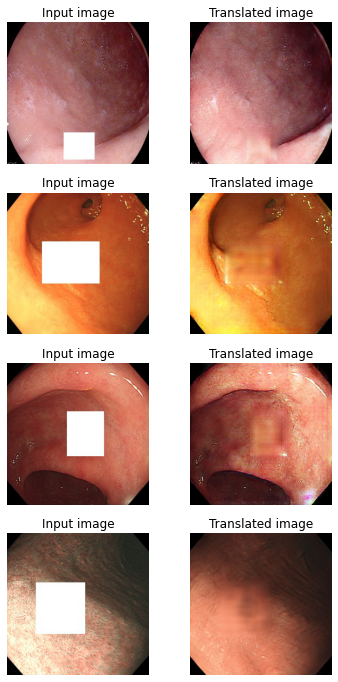

119/119 [==============================] - 169s 1s/step - G_loss: 1.0479 - F_loss: 1.6537 - D_X_loss: 0.0243 - D_Y_loss: 0.2506
Epoch 452/500
119/119 [==============================] - 167s 1s/step - G_loss: 1.1123 - F_loss: 1.7525 - D_X_loss: 0.0232 - D_Y_loss: 0.2504
Epoch 453/500
119/119 [==============================] - 167s 1s/step - G_loss: 1.0661 - F_loss: 1.7405 - D_X_loss: 0.0219 - D_Y_loss: 0.2502
Epoch 454/500
119/119 [==============================] - 168s 1s/step - G_loss: 1.0456 - F_loss: 1.6843 - D_X_loss: 0.0212 - D_Y_loss: 0.2505
Epoch 455/500
119/119 [==============================] - 167s 1s/step - G_loss: 1.0194 - F_loss: 1.7013 - D_X_loss: 0.0154 - D_Y_loss: 0.2507
Epoch 456/500
119/119 [==============================] - 167s 1s/step - G_loss: 1.0504 - F_loss: 1.6856 - D_X_loss: 0.0222 - D_Y_loss: 0.2499
Epoch 457/500
119/119 [==============================] - 167s 1s/step - G_loss: 1.2939 - F_loss: 1.7528 - D_X_loss: 0.0101 - D_Y_loss: 0.2505
Epoch 458/500
119/11

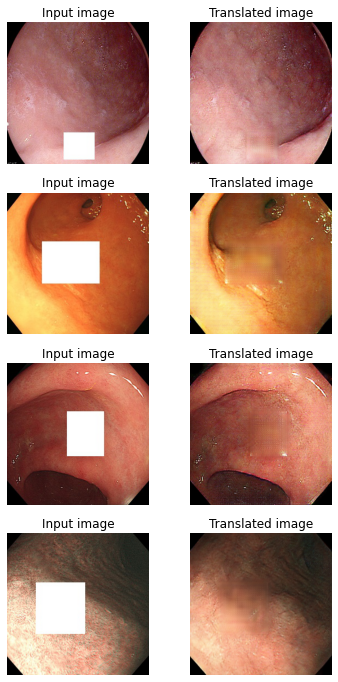

119/119 [==============================] - 170s 1s/step - G_loss: 1.0564 - F_loss: 1.6829 - D_X_loss: 0.0216 - D_Y_loss: 0.2503
Epoch 462/500
119/119 [==============================] - 166s 1s/step - G_loss: 1.0357 - F_loss: 1.6565 - D_X_loss: 0.0199 - D_Y_loss: 0.2501
Epoch 463/500
119/119 [==============================] - 168s 1s/step - G_loss: 1.0558 - F_loss: 1.6635 - D_X_loss: 0.0200 - D_Y_loss: 0.2503
Epoch 464/500
119/119 [==============================] - 166s 1s/step - G_loss: 1.0833 - F_loss: 1.6708 - D_X_loss: 0.0211 - D_Y_loss: 0.2506
Epoch 465/500
119/119 [==============================] - 166s 1s/step - G_loss: 1.0375 - F_loss: 1.6477 - D_X_loss: 0.0265 - D_Y_loss: 0.2502
Epoch 466/500
119/119 [==============================] - 167s 1s/step - G_loss: 1.0292 - F_loss: 1.6520 - D_X_loss: 0.0220 - D_Y_loss: 0.2503
Epoch 467/500
119/119 [==============================] - 166s 1s/step - G_loss: 1.0142 - F_loss: 1.6574 - D_X_loss: 0.0244 - D_Y_loss: 0.2502
Epoch 468/500
119/11

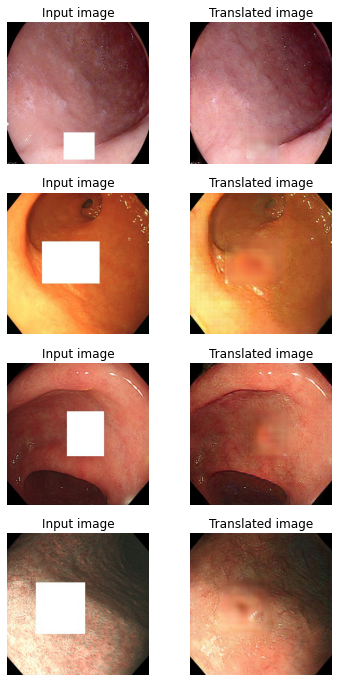

119/119 [==============================] - 169s 1s/step - G_loss: 1.1060 - F_loss: 1.7079 - D_X_loss: 0.0131 - D_Y_loss: 0.2504
Epoch 472/500
119/119 [==============================] - 166s 1s/step - G_loss: 1.3099 - F_loss: 1.7210 - D_X_loss: 0.0220 - D_Y_loss: 0.2499
Epoch 473/500
119/119 [==============================] - 165s 1s/step - G_loss: 1.1472 - F_loss: 1.7276 - D_X_loss: 0.0265 - D_Y_loss: 0.2505
Epoch 474/500
119/119 [==============================] - 166s 1s/step - G_loss: 1.3670 - F_loss: 1.7358 - D_X_loss: 0.0183 - D_Y_loss: 0.2499
Epoch 475/500
119/119 [==============================] - 165s 1s/step - G_loss: 1.4812 - F_loss: 1.7235 - D_X_loss: 0.0211 - D_Y_loss: 0.2500
Epoch 476/500
  3/119 [..............................] - ETA: 2:08 - G_loss: 1.5697 - F_loss: 1.7917 - D_X_loss: 0.0155 - D_Y_loss: 0.2477

KeyboardInterrupt: 

: 

In [83]:
plotter = GANMonitor()
checkpoint_filepath = "../model/CycleGan/endoscope/cyclegan_checkpoints_{epoch:03d}.tf"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only= True
)

histo=cycle_gan_model.fit(
    tf.data.Dataset.zip((tf_train_x, tf_train_y)),
    initial_epoch=400,
    epochs=500,
    callbacks=[plotter,model_checkpoint_callback]
)